<a href="https://colab.research.google.com/github/Noznoc/access-classifier/blob/main/WIP_Exterior_Accessibility_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Binary Classifier Building Enterances
**Author:** Alex Lane and Julia Conzon <br>
**Date created:** 2021/03/18<br>
**Description:** Training an image classifier from scratch on the Mapillary API imagery collected on building enterances. This workflow follows the Classifier from [Scratch Keras tutorial](https://keras.io/examples/vision/image_classification_from_scratch/).

## Setup


Import the necessary Python packages for evaluation.

In [2]:
import sys # for importing directory
import tensorflow as tf # for modeling
from tensorflow import keras # for modeling
from keras.models import Sequential # following Wu et al. (2019) sequential model was used
from tensorflow.keras import layers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Activation
import matplotlib.pyplot as plt # for visualizing images
import numpy as np

## Load the data: "Accessible" and "Inaccessible" dataset

Compile data from the Mapillary API, [scripts accessible in another notebook]()

Confirm folder of Mapillary API imagery exists. Subfolders should be `Accessible` and `Inaccessible`, which each contain the images that represent the category.


In [ ]:
!ls OSM_And_Mapillary_Sequence_Dataset

import os, random
import shutil

# Function that randomly moves image files based on source directory, destination directory and number of files wanting to move
def randomly_move_imgs(src_dir, dst_dir, n):
  file_list = os.listdir(src_dir)
  for j in range(n):
    img = random.choice(file_list)
    shutil.move(src_dir + img, dst_dir)

# Read "OSM_And_Mapillary_Sequence_Dataset/Accessible" folder randomly select n and move to "Test/Accessible" folder
n = 10
src_dir = "./OSM_And_Mapillary_Sequence_Dataset/Train/Accessible/"
dst_dir = "./OSM_And_Mapillary_Sequence_Dataset/Test/Accessible"
# randomly_move_imgs(src_dir, dst_dir, n)

# Read "OSM_And_Mapillary_Sequence_Dataset/Inaccessible" folder and randomly select n and move to "Test/Inaccessible" folder
n = 10
src_dir = "./OSM_And_Mapillary_Sequence_Dataset/Train/Inaccessible/"
dst_dir = "./OSM_And_Mapillary_Sequence_Dataset/Test/Inaccessible"
# randomly_move_imgs(src_dir, dst_dir, n)

Model  Test  Train


## Preprocess Data


Steps includes standardizing the images to the same size (`image_size`). 

Keras `seed` command is an optional parameter to offer a random seed for shuffling and transforming the images to augment the dataset. 

In [3]:
image_size = (180, 180)
batch_size = 32#103#16


# Assign to a train dataset (85%)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "OSM_And_Mapillary_Sequence_Dataset/Train",
    validation_split=0.15,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode = 'binary',
)

# Assign to a validation dataset (15%)
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "OSM_And_Mapillary_Sequence_Dataset/Train",
    validation_split=0.15,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode = 'binary',
)

# confirm classes
class_names = train_ds.class_names
print(class_names)

Found 824 files belonging to 2 classes.
Using 701 files for training.
Found 824 files belonging to 2 classes.
Using 123 files for validation.
['Accessible', 'Inaccessible']


## Visualize Data

Label 1 is "inaccessible" and label 0 is "accessible".


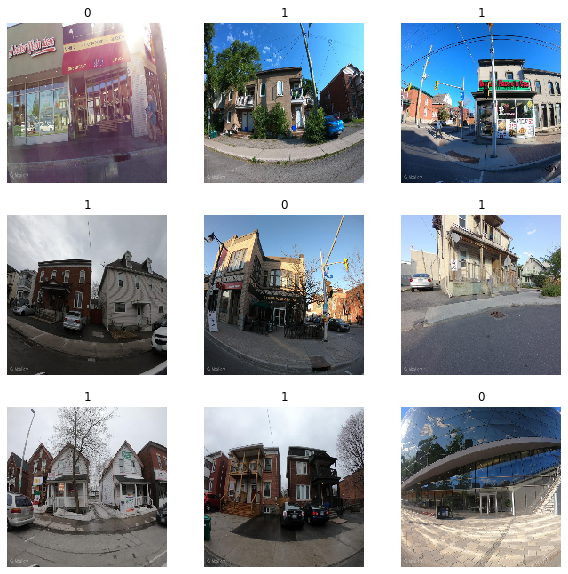

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


## Augmentation

Considering the small sample for training, the dataset will be augmented, that is randomly flipped horizontally, rotated, contrasted and zoomed. Order impacts the image gets distorted. Different tests were applied to identify an optimal augmentation, as seen below:

https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/


In [ ]:
data_augmentation = keras.Sequential(
    [
        # Reminder, the order in which transformations are called significantly 
        # affects the final augmentation.
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomTranslation(0.1,0.1),
        layers.experimental.preprocessing.RandomZoom(0.2),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomContrast(0.01),
        #layers.experimental.preprocessing.RandomHeight(0.5),
        #layers.experimental.preprocessing.RandomWidth(0.5),
        #layers.experimental.preprocessing.Resizing(180, 180),
    ]
)

Visualize the augmented samples:


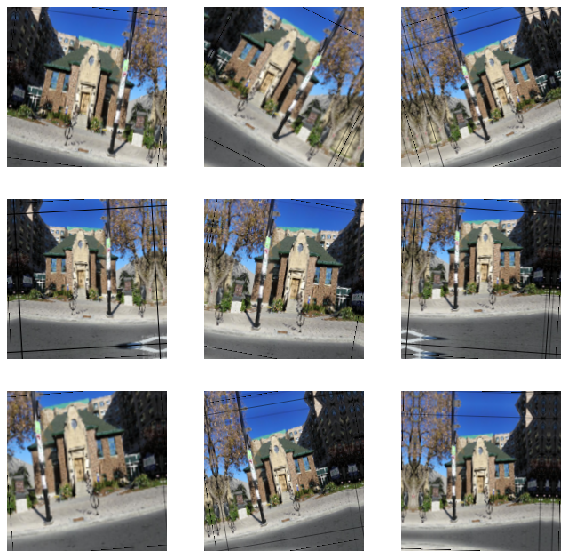

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


## Configure Dataset

Following documentation from Keras creator, François Chollet, use buffered prefetching to yield data from disk without having I/O becoming blocking:


In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
valid_ds = valid_ds.prefetch(buffer_size=32)


## Build Model

Start off with a simple Sequential model, following Wu et al. (2019)



Tensor("input_4:0", shape=(None, 180, 180, 3), dtype=float32)
Tensor("dense_7/Sigmoid:0", shape=(None, 1), dtype=float32)


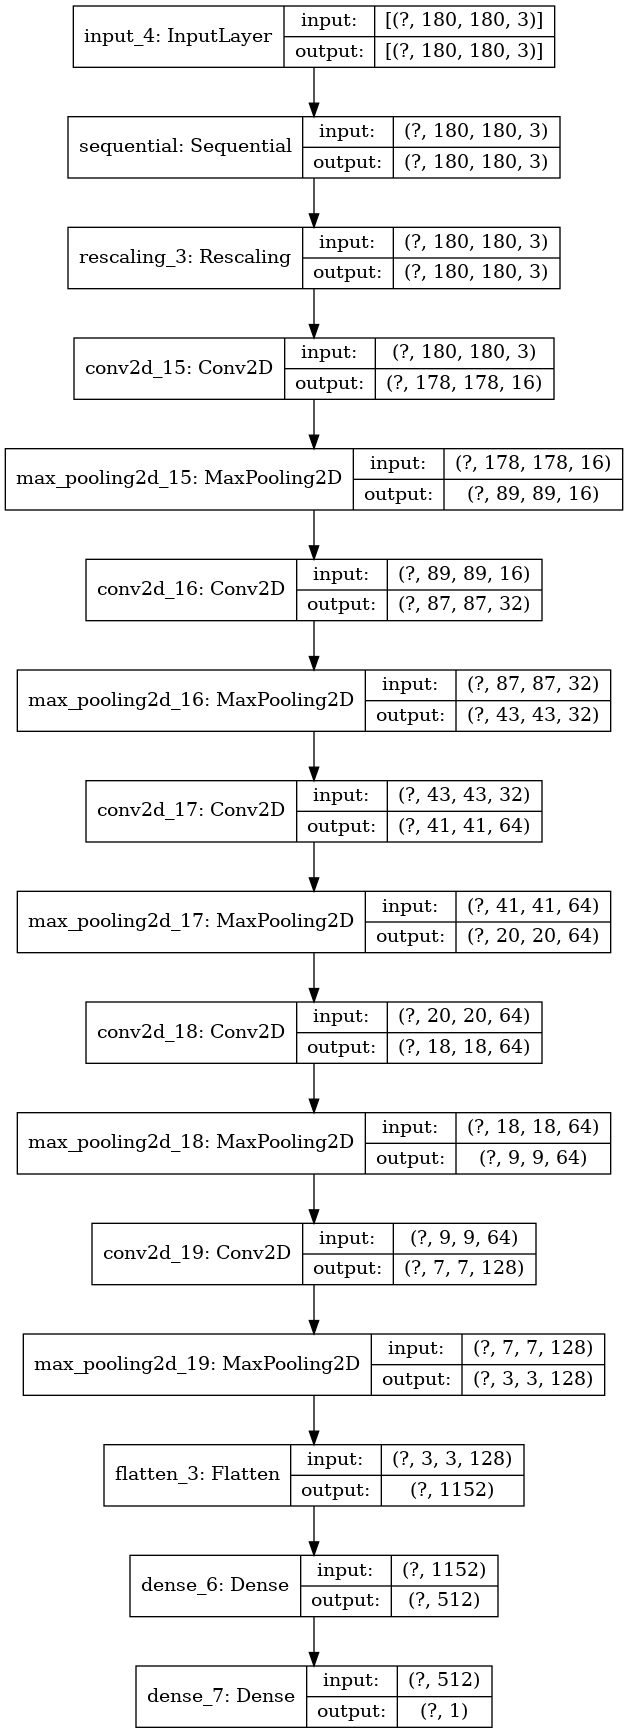

In [ ]:
# MODEL ARCHITECTURES BY WU ET AL (2019):

# CNN2: CONV(64, 3), RELU, CONV(32, 3), RELU, POOL(2), CONV(64, 3), FC(128), RELU, FC(2), SOFTMAX.
# CNN3: [CONV(128, 3), RELU, POOL(2)], [CONV(64 3), RELU, POOL(2)], [CONV(32, 3), RELU, POOL(2)], DROPOUT(), RELU, FC(512), RELU, FC(2), SOFTMAX.
# CNN5: CONV(128, 3), RELU, CONV(128, 3), RELU, POOL(2), CONV(64, 3), DROPOUT(), RELU, CONV(64, 3), RELU, POOL(2), CONV(32, 3), DROPOUT(), RELU, POOL(2), FC(512), RELU, DROPOUT(), FC(256), RELU, FC(2), SOFTMAX

# Model parameters
input_shape = image_size + (3,) # add RGB code of 3 to image shape for Keras Input() argument
num_classes = 2 # number of classes being defined

# Initialize model
inputs = keras.Input(shape=input_shape) # establish inputs e.g., (180, 180, 3) is the width and height dimension and 3 represents RGB
print(inputs)
layer = data_augmentation(inputs) # first "layer" is augmented images that are called in the previous script

# rescale the image to 1 and 0, not 255 RGB
layer = layers.experimental.preprocessing.Rescaling(1.0 / 255)(layer)

# Building blocks for CNN

layer = Conv2D(filters=16, kernel_size=3, activation='relu')(layer)
layer = MaxPooling2D(pool_size = (2,2))(layer)
#layer = Dropout(0.5)(layer)

layer = Conv2D(filters=32, kernel_size=3, activation='relu')(layer)
layer = MaxPooling2D(pool_size = (2,2))(layer)
#layer = Dropout(0.5)(layer)

layer = Conv2D(filters=64, kernel_size=3, activation='relu')(layer)
layer = MaxPooling2D(pool_size = (2,2))(layer)
#layer = Dropout(0.5)(layer)

layer = Conv2D(filters=64, kernel_size=3, activation='relu')(layer)
layer = MaxPooling2D(pool_size = (2,2))(layer)

layer = Conv2D(filters=128, kernel_size=3, activation='relu')(layer)
layer = MaxPooling2D(pool_size = (2,2))(layer)
#layer = Dropout(0.5)(layer)

#layer = Conv2D(filters=128, kernel_size=3)(layer)

layer = Flatten()(layer)

layer = Dense(512, activation='relu')(layer)

#layer = layers.GlobalAveragePooling2D()(layer)
outputs = Dense(1, activation='sigmoid')(layer) # or use sigmoid to view probability distribution

print(outputs)
'''
layer = Conv2D(filters=128, kernel_size=3, strides=2)(layer) #, padding='same'
layer = Activation('relu')(layer)
layer = MaxPooling2D(pool_size = (2,2))(layer)

layer = Conv2D(filters=64, kernel_size=3)(layer)
layer = Activation('relu')(layer)
layer = MaxPooling2D(pool_size = (2,2))(layer)

layer = Conv2D(filters=32, kernel_size=3)(layer)
layer = Activation('relu')(layer)
layer = MaxPooling2D(pool_size = (2,2))(layer)

# Dropout used for CNN3 and CNN5
layer = Dropout(0.25)(layer)

layer = Activation('relu')(layer)

# Fully-connected layer
layer = Dense(360, activation='relu')(layer)
#layer = Activation('relu')(layer)
#layer = Dense(2, activation='relu')(layer)
#outputs = keras.layers.Softmax()(layer)
#layer = Dense(num_classes, activation='relu')(layer)
layer = layers.GlobalAveragePooling2D()(layer)
layer = Dense(2)(layer) # or use sigmoid to view probability distribution
outputs = Activation('softmax')(layer)
'''
# Initialize model with building blocks
model = keras.Model(inputs, outputs)

# Plot model architecture
keras.utils.plot_model(model, to_file='model.png', rankdir='TR', show_shapes='True')

# Print summary of model
# model.summary()

# Print each layer
# for layer in model.layers:
#   print(layer.output_shape)

# Train Model

In [ ]:
# Number of epochs
epochs = 50

# Add callbacks to log file
callbacks = [
    keras.callbacks.ModelCheckpoint("OSM_And_Mapillary_Sequence_Data/Model/Epochs/{epoch}.h5"),
]

# Compile CNN, following default optimizer and loss function for binary classification
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)


model.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, shuffle=True)

Epoch 1/50
22/22 [==============================] - 16s 711ms/step - loss: 0.6941 - accuracy: 0.5221 - val_loss: 0.6665 - val_accuracy: 0.5854
Epoch 2/50
22/22 [==============================] - 16s 705ms/step - loss: 0.6759 - accuracy: 0.5863 - val_loss: 0.6442 - val_accuracy: 0.6098
Epoch 3/50
22/22 [==============================] - 16s 734ms/step - loss: 0.6545 - accuracy: 0.6648 - val_loss: 0.6213 - val_accuracy: 0.6829
Epoch 4/50
22/22 [==============================] - 15s 660ms/step - loss: 0.5928 - accuracy: 0.7076 - val_loss: 0.6194 - val_accuracy: 0.6179
Epoch 5/50
22/22 [==============================] - 15s 687ms/step - loss: 0.5981 - accuracy: 0.6805 - val_loss: 0.5701 - val_accuracy: 0.7317
Epoch 6/50
22/22 [==============================] - 16s 739ms/step - loss: 0.5861 - accuracy: 0.7047 - val_loss: 0.5865 - val_accuracy: 0.6829
Epoch 7/50
22/22 [==============================] - 16s 736ms/step - loss: 0.5701 - accuracy: 0.7218 - val_loss: 0.6404 - val_accuracy: 0.7154

# Test Model

I think the scores were opposite, so I changed the code somewhat.

In [ ]:
import os

directory = r'./OSM_And_Mapillary_Sequence_Dataset/Test/Accessible/'
correctInaccessible = 0
correctAccessible = 0

for testImage in os.listdir(directory):
    if testImage.endswith(".png"):
        #print(os.path.join(directory, testImage))
        img = keras.preprocessing.image.load_img(os.path.join(directory, testImage), 
                                                 target_size=image_size)
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)  # create batch axis

        predictions = model.predict(img_array)
        score = predictions[0]
        print(testImage)
        print(
            "This image of building entrance is %.2f percent accessible and %.2f percent inaccessible."
            % (100 * (1 - score), 100 * score)
        )
        if((1 - score) > 0.5):
            print("✅ - This image has been correctly classified as accessible.\n")
            correctAccessible += 1
        elif ((1 - score) == 0.5):
            print("❓ - The model say this image has equal probability of being accesible or inaccessible.\n")
        else:
            print("❌ - This image has been incorrectly classified as inaccessible.\n")

directory = r'./OSM_And_Mapillary_Sequence_Dataset/Test/Inaccessible/'
for testImage in os.listdir(directory):
    if testImage.endswith(".png"):
        #print(os.path.join(directory, testImage))
        img = keras.preprocessing.image.load_img(os.path.join(directory, testImage), 
                                                 target_size=image_size)
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)  # create batch axis

        predictions = model.predict(img_array)
        score = predictions[0]
        print(testImage)
        print(
            "This image of building entrance is %.2f percent accessible and %.2f percent inaccessible."
            % (100 * (1 - score), 100 * score)
        )
        if(score > 0.5):
            print("✅ - This image has been correctly classified as inaccessible.\n")
            correctInaccessible += 1
        elif (score == 0.5):
            print("❓ - The model say this image has equal probability of being accesible or inaccessible.\n")
        else:
            print("❌ - This image has been incorrectly classified as accessible.\n")

print("%i of the 10 accessible images were correctly classified as accessible." % correctAccessible)
print("%i of the 10 inaccessible images were correctly classified as inaccessible." % correctInaccessible)


Staples 1595 Merivale Road 75.png
This image of building entrance is 99.62 percent accessible and 0.38 percent inaccessible.
✅ - This image has been correctly classified as accessible.

0245 -Q2FqoePMq5qkC4FM_IU6Q.png
This image of building entrance is 23.80 percent accessible and 76.20 percent inaccessible.
❌ - This image has been incorrectly classified as inaccessible.

0566 QR6cBiunpB_PXCisWczWPw.png
This image of building entrance is 98.20 percent accessible and 1.80 percent inaccessible.
✅ - This image has been correctly classified as accessible.

Albert at Bay Suite Hotel 435 Albert Street 0.png
This image of building entrance is 99.38 percent accessible and 0.62 percent inaccessible.
✅ - This image has been correctly classified as accessible.

0009 A8-IT0RqrOz9YlybO7_UEg.png
This image of building entrance is 99.45 percent accessible and 0.55 percent inaccessible.
✅ - This image has been correctly classified as accessible.

Billings Bridge Shopping Centre 2277 Riverside Drive 63